In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

In [310]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
comb = train.append(test)

## Missing values :   
As previously seen age , Cabin, Embarked, Fare have missing values.


In [311]:
comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [312]:
comb.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


## 1. Embarked

Since embarked has only 2 missing values, we replace it with the most occuring value

In [313]:
comb.groupby('Embarked').size()

Embarked
C    270
Q    123
S    914
dtype: int64

In [314]:
# filling the missing value with the mode
comb.Embarked.fillna(comb.Embarked.mode()[0], inplace = True)

## dummy encoding ...
embarked_dummies = pd.get_dummies(comb['Embarked'], prefix='Embarked')    
comb = pd.concat([comb, embarked_dummies], axis=1)

# dropping the Cabin column
comb.drop('Embarked', inplace = True,axis =1)


## 2. Cabin

In [315]:
# filling the missing values with "U" for feature Cabin
comb.Cabin.fillna("U",inplace = True)

# extracting the first letter from the text
comb.Cabin = comb.Cabin.map(lambda c:c[0])


In [316]:
comb.Cabin.unique()

array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [317]:

# dummy encoding ...
cabin_dummies = pd.get_dummies(comb['Cabin'], prefix='Cabin')    
comb = pd.concat([comb, cabin_dummies], axis=1)

# dropping the Cabin column
comb.drop('Cabin', inplace = True,axis =1)

In [318]:
comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Embarked_C   1309 non-null   uint8  
 11  Embarked_Q   1309 non-null   uint8  
 12  Embarked_S   1309 non-null   uint8  
 13  Cabin_A      1309 non-null   uint8  
 14  Cabin_B      1309 non-null   uint8  
 15  Cabin_C      1309 non-null   uint8  
 16  Cabin_D      1309 non-null   uint8  
 17  Cabin_E      1309 non-null   uint8  
 18  Cabin_F      1309 non-null   uint8  
 19  Cabin_G

## 3. Ticket

There are no missing values

we see that the ticket is having either alpha numeric or simply numeric.We try to extract prefixes from the ticket data.



In [319]:
#ticket = comb.Ticket[0]
comb.Ticket = comb.Ticket.map(lambda x:x.replace('.',''))
comb.Ticket = comb.Ticket.map(lambda x:x.replace('/',''))
comb.Ticket = comb.Ticket.map(lambda x:x.split())
comb.Ticket = comb.Ticket.map(lambda x: x[0])
comb.Ticket = comb.Ticket.map(lambda x: "U" if (x.isnumeric()) else x)
ticket_dummies = pd.get_dummies(comb['Ticket'], prefix = "Ticket")
comb = pd.concat([comb, ticket_dummies], axis=1)
comb.drop('Ticket',inplace = True, axis = 1)


## 4. Age
### We fill the age with random values based on mean and sd
(https://medium.com/@praveen.orvakanti/this-will-help-you-score-95-percentile-in-the-kaggle-titanic-ml-competition-aa2b3fd1b79b)

In [320]:
data = [comb]
for df in data:
    # calculating mean and std
    mean = df.Age.mean()
    std  = df.Age.std()
    is_null = df.Age.isnull().sum()
    
    # finding the random values to be filled
    rand_age = np.random.randint(mean-std,mean+std,size = is_null)
    
    # filling the train data with the missing values
    age = df.Age.copy()
    age[np.isnan(age)] = rand_age
    df.Age = age
    df.Age = df.Age.astype(int)



## 5. Fare.
### We will replace the missing value in test data for fare with mode value

In [321]:
comb.Fare = comb.fillna(comb.Fare.mode()[0])

## Creating new features from parch and sibsp
## 6. Family
### We create 2 features called family and is_alone fromt these

In [322]:

comb["Family"] = comb.Parch + comb.SibSp
comb["Is_alone"] = comb.Family.map(lambda x: 1 if x == 0  else 0)
comb["Small_Family"] = comb.Family.map(lambda x: 1 if x in (1,2,3,4) else 0)
comb["Large_Family"] = comb.Family.map(lambda x: 1 if x >4  else 0)

comb

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked_C,...,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_U,Ticket_WC,Ticket_WEP,Family,Is_alone,Small_Family,Large_Family
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22,1,0,1,0,...,0,0,0,0,0,0,1,0,1,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,2,1,...,0,0,0,0,0,0,1,0,1,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26,0,0,3,0,...,1,0,0,0,0,0,0,1,0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,4,0,...,0,0,0,1,0,0,1,0,1,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35,0,0,5,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,16,0,0,1305,0,...,0,0,0,0,0,0,0,1,0,0
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39,0,0,1306,1,...,0,0,0,0,0,0,0,1,0,0
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38,0,0,1307,0,...,0,0,0,0,0,0,0,1,0,0
416,1308,NaN,3,"Ware, Mr. Frederick",male,35,0,0,1308,0,...,0,0,0,1,0,0,0,1,0,0


## 7. Sex

In [323]:
comb.Sex = comb.Sex.map(lambda x: 1 if x == "Male" else 0)

In [324]:
comb

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked_C,...,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_U,Ticket_WC,Ticket_WEP,Family,Is_alone,Small_Family,Large_Family
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22,1,0,1,0,...,0,0,0,0,0,0,1,0,1,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,2,1,...,0,0,0,0,0,0,1,0,1,0
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26,0,0,3,0,...,1,0,0,0,0,0,0,1,0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,4,0,...,0,0,0,1,0,0,1,0,1,0
4,5,0.0,3,"Allen, Mr. William Henry",0,35,0,0,5,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",0,16,0,0,1305,0,...,0,0,0,0,0,0,0,1,0,0
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39,0,0,1306,1,...,0,0,0,0,0,0,0,1,0,0
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",0,38,0,0,1307,0,...,0,0,0,0,0,0,0,1,0,0
416,1308,NaN,3,"Ware, Mr. Frederick",0,35,0,0,1308,0,...,0,0,0,1,0,0,0,1,0,0


## 8.Pclass

In [325]:
pclass_dummies = pd.get_dummies(comb.Pclass,prefix = "Pclass")
comb = pd.concat([comb,pclass_dummies], axis =1)
comb.drop('Pclass',inplace = True,axis =1)

## 9. Name 

We will extract titles from name.   


In [326]:
# Extracting titles and giving them numbers
titles = comb.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
titles.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [327]:
titles.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Ms            2
Mlle          2
Major         2
Jonkheer      1
Dona          1
Mme           1
Sir           1
Capt          1
Lady          1
Countess      1
Don           1
Name: Name, dtype: int64

### We can use  Mr, Miss, Mrs, Master , ... as follows

 "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"

In [328]:
data = [comb]
for df in data:
    # extract titles
    df["Title"] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # replacing the titles with numbers
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'],"Miss")
    df['Title'] = df['Title'].replace(['Capt', 'Col','Major', 'Rev','Dr'], "Officer")
    df['Title'] = df['Title'].replace(['Jonkheer','Don','Sir', 'the Countess','Lady','Countess','Dona'], "Royalty")
    df['Title'] = df['Title'].replace(['Mme'], "Mrs")
    
    
    df.drop(["Name"], axis = 1, inplace = True)
    
   

In [329]:
title_dummies = pd.get_dummies(comb.Title,prefix = "Titles")
comb = pd.concat([comb,title_dummies],axis = 1)
comb.drop('Title',inplace = True, axis = 1)

In [330]:
comb.drop('PassengerId',inplace = True, axis = 1)
   

In [331]:
comb.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,...,Large_Family,Pclass_1,Pclass_2,Pclass_3,Titles_Master,Titles_Miss,Titles_Mr,Titles_Mrs,Titles_Officer,Titles_Royalty
0,0.0,0,22,1,0,1,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
1,1.0,0,38,1,0,2,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,1.0,0,26,0,0,3,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
3,1.0,0,35,1,0,4,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
4,0.0,0,35,0,0,5,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0


### all set

In [332]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [333]:
# separating the test and train
train = comb.iloc[:891]
test = comb.iloc[891:]

In [334]:
test = test.drop('Survived', axis =1).copy()

In [336]:
train

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,...,Large_Family,Pclass_1,Pclass_2,Pclass_3,Titles_Master,Titles_Miss,Titles_Mr,Titles_Mrs,Titles_Officer,Titles_Royalty
0,0.0,0,22,1,0,1,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
1,1.0,0,38,1,0,2,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,1.0,0,26,0,0,3,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
3,1.0,0,35,1,0,4,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
4,0.0,0,35,0,0,5,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,0,27,0,0,887,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
887,1.0,0,19,0,0,888,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
888,0.0,0,20,1,2,889,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
889,1.0,0,26,0,0,890,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [335]:
print(train.shape,test.shape)

(891, 68) (418, 67)


In [337]:
X_train = train.drop(["Survived"], axis=1)
Y_train = train["Survived"]
X_test  = test.copy()
x_train, x_test, y_train, y_test = train_test_split(  X_train1,Y_train1,test_size=0.2, random_state=42)

### Using all the features as it is
## Random Forest

RF Accuracy: 81.01%
The cross validated score for Random forest is: 82.45


Text(0.5, 1.05, 'Confusion_matrix for RF')

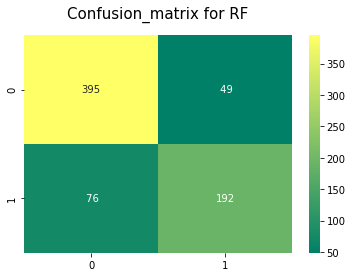

In [338]:

##Random forest
clf = RandomForestClassifier(criterion='entropy', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
clf.fit(x_train,  y_train)
print("RF Accuracy: "+repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result_rf=cross_val_score(clf,x_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for Random forest is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(clf,x_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for RF', y=1.05, size=15)

In [340]:
pid = pd.read_csv("test.csv")
result = clf.predict(X_test)
submission = pd.DataFrame({'PassengerId':pid.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic Predictions RF3.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

(418, 2)
Saved file: Titanic Predictions RF3.csv


## kaggle score : 0.78708

In [341]:
logreg = LogisticRegression()
logreg.fit(X_train,  Y_train)
result = logreg.predict(X_test)
submission = pd.DataFrame({'PassengerId':pid.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic Predictions LG2.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

(418, 2)
Saved file: Titanic Predictions LG2.csv


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## kaggle score :0.77272

### Feature importance

In [342]:
print(X_train.shape, Y_train.shape, X_test.shape)

(891, 67) (891,) (418, 67)


In [343]:
rfc = RandomForestClassifier(n_estimators = 100, max_features = 'sqrt')
res = rfc.fit(X_train,Y_train)

In [344]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = res.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

<AxesSubplot:ylabel='feature'>

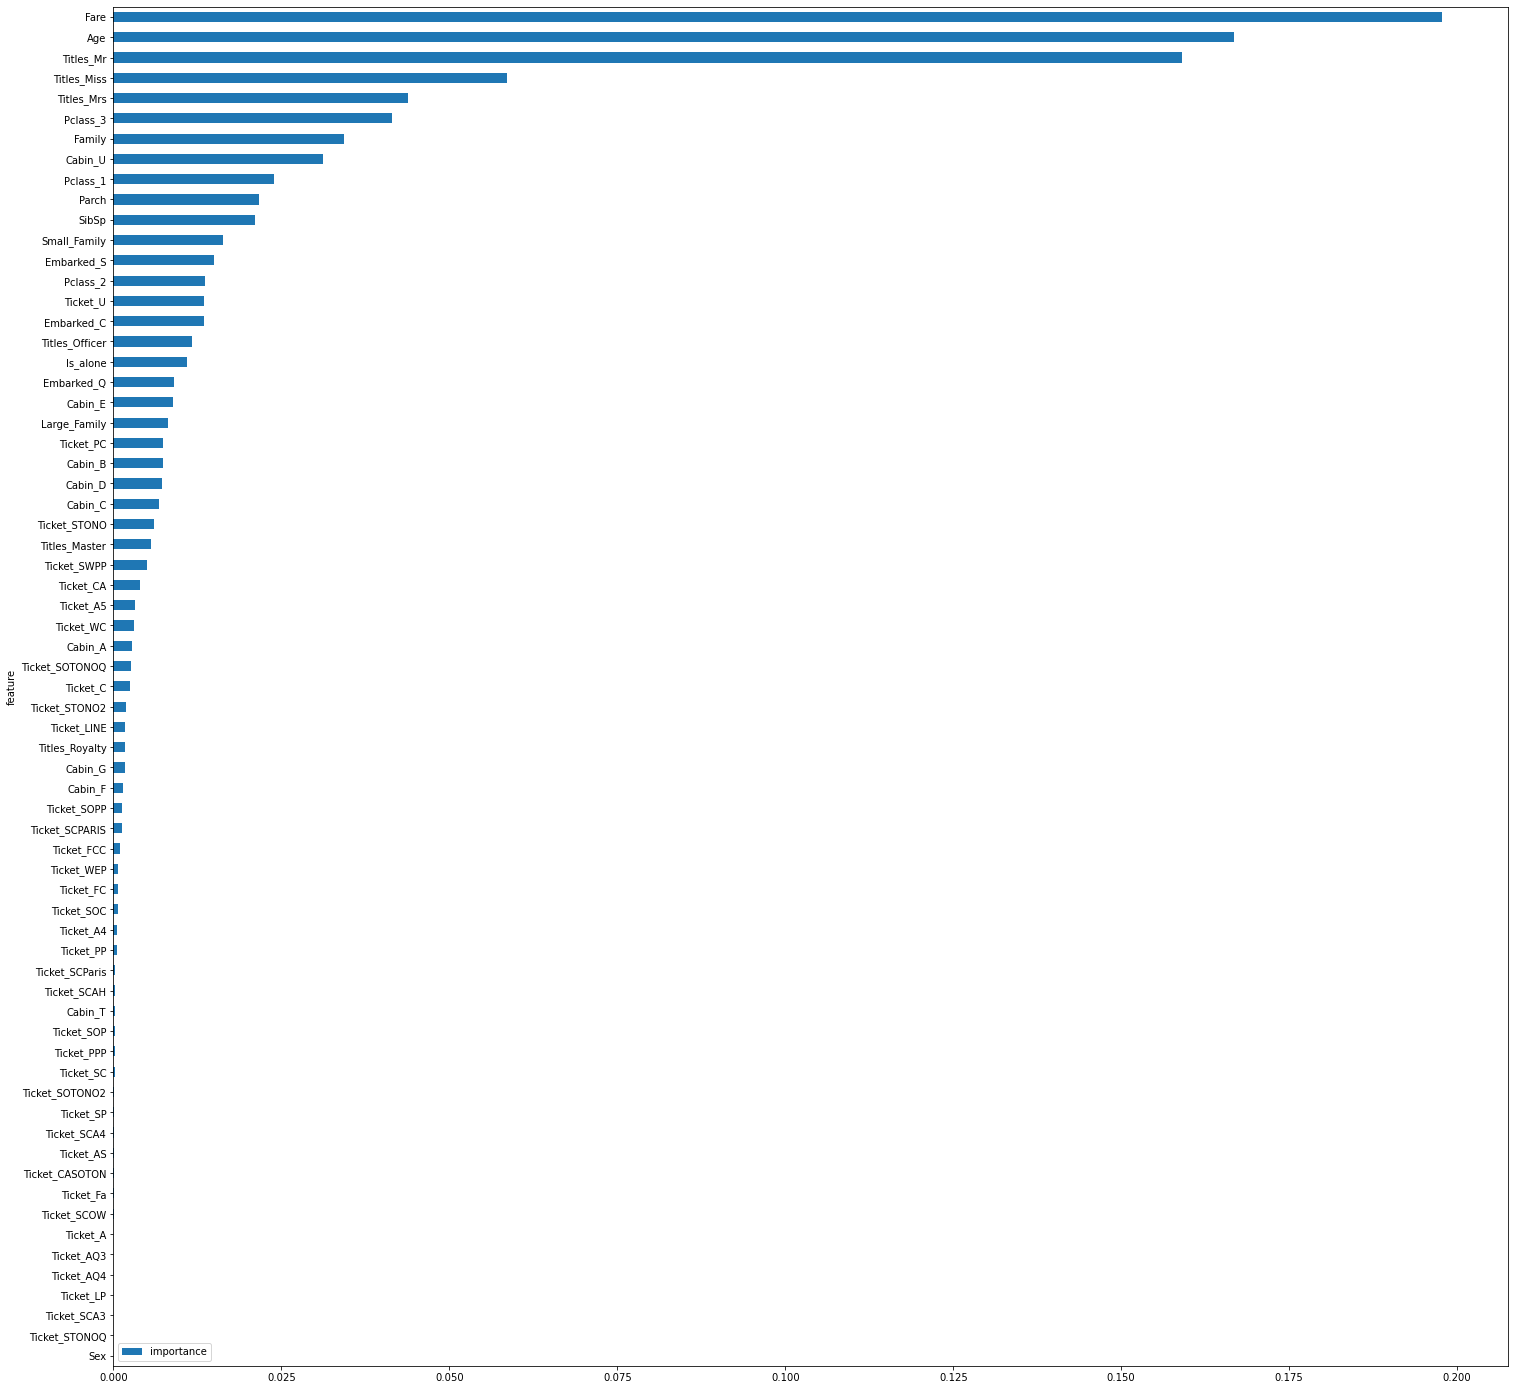

In [345]:
features.plot(kind='barh', figsize=(25, 25))

In [346]:
model = SelectFromModel(rfc, prefit=True)
X_train = model.transform(X_train)
X_test = model.transform(X_test)
print(X_train.shape,X_test.shape)

(891, 12) (418, 12)


## training and prediction

In [347]:
print(X_train.shape,Y_train.shape,X_test.shape)

(891, 12) (891,) (418, 12)


In [348]:

x_train, x_test, y_train, y_test = train_test_split(  X_train,Y_train,test_size=0.2, random_state=42)


In [349]:
print(y_train.shape)

(712,)


## Random Forest

RF Accuracy: 82.12%
The cross validated score for Random forest is: 82.3


Text(0.5, 1.05, 'Confusion_matrix for RF')

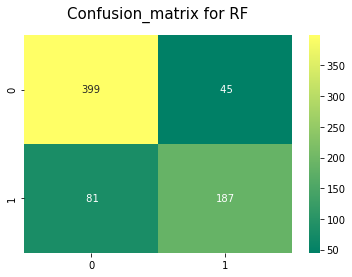

In [350]:

##Random forest
clf = RandomForestClassifier(criterion='entropy', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
clf.fit(x_train,  y_train)
print("RF Accuracy: "+repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result_rf=cross_val_score(clf,x_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for Random forest is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(clf,x_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for RF', y=1.05, size=15)

In [353]:
result = clf.predict(X_test)
submission = pd.DataFrame({'PassengerId':pid.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic Predictions RF3.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

(418, 2)
Saved file: Titanic Predictions RF3.csv


### Kaggle accuracy for RF : 0.79186

## Logistic Regression

In [355]:
logreg = LogisticRegression()
logreg.fit(X_train,  Y_train)
result = logreg.predict(X_test)
submission = pd.DataFrame({'PassengerId':pid.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic Predictions LG3.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)


(418, 2)
Saved file: Titanic Predictions LG3.csv


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Kaggle accuracy for LG : 0.77990

## Logistic Regression Hyper tuning

In [356]:
from sklearn.model_selection import GridSearchCV
logreg = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_logreg_acc = GridSearchCV(logreg, param_grid = grid_values,scoring = 'recall')
grid_logreg_acc.fit(X_train, Y_train)

#Predict values based on new parameters
y_pred_acc = grid_logreg_acc.predict(X_test)
submission = pd.DataFrame({'PassengerId':pid.PassengerId,'Survived':y_pred_acc})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic Predictions LG hypertuned1.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/envs/py38/lib/

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

(418, 2)
Saved file: Titanic Predictions LG hypertuned1.csv


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

### Kaggle score with LR with hypertuning : 0.77990

We see that attribute name should not have comma for XGBoost  classifier, so we will change the names

## XGBoost

In [357]:
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)
result = xgb.predict(X_test)
submission = pd.DataFrame({'PassengerId':pid.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic Predictions XGBoost3.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:59:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(418, 2)
Saved file: Titanic Predictions XGBoost3.csv


### Kaggle Score XGBoost : 0.76315

### Tuning the XGBoost

In [358]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, precision_recall_curve, auc, make_scorer, confusion_matrix, f1_score, fbeta_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
param_test1 = {
    'n_estimators': [500,750],
    'max_depth': [3,5],
    'min_child_weight': [1,3],
    'gamma':[0,0.1],
    'subsample':[0.8,1],
    'colsample_bytree':[0.5,0.6],
    'reg_alpha':[0, 0.001],
    'learning_rate': [0.01, 0.02]
}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
gsearch1 = GridSearchCV(estimator = XGBClassifier(), 
                       param_grid = param_test1, 
                       scoring=scoring, iid=False,
                       cv=5, verbose = 5, 
                       refit='Accuracy')
gsearch1.fit(X_train, Y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:00:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.861, Accuracy=0.726, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:00:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.809, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:00:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1,

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.881, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:00:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.853, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:00:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1,

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.900, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:00:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.861, Accuracy=0.676, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:00:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0,

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.802, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:00:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.882, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:00:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.850, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:00:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsamp

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.860, Accuracy=0.726, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:00:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.809, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:00:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Star

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.881, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:00:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.853, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:00:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Star

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.898, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:00:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.860, Accuracy=0.676, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:00:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting i

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.802, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:00:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.884, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:00:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.849, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:00:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.899, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:00:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.864, Accuracy=0.682, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:00:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.809, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:00:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.886, Accuracy=0.798, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:00:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.845, Accuracy=0.826, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:00:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.900, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:00:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.862, Accuracy=0.626, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:00:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.802, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:00:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.887, Accuracy=0.826, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:00:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.839, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:00:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.901, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:00:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.863, Accuracy=0.682, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:00:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.811, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:00:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.886, Accuracy=0.798, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:00:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.845, Accuracy=0.826, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:00:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.899, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:00:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.862, Accuracy=0.626, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:00:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.802, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:00:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.883, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:00:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.838, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:00:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.901, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:00:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.858, Accuracy=0.777, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:00:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.817, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:00:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, sub

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.850, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:00:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.899, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:00:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.861, Accuracy=0.782, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:00:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.817, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:00:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, t

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.884, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:00:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.851, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:00:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.899, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:00:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.858, Accuracy=0.777, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:00:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.818, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:00:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.882, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:00:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.849, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:00:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.899, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:00:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.861, Accuracy=0.782, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:00:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting i

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.817, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:00:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.884, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:00:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.852, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:00:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.899, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:00:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XG

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.856, Accuracy=0.777, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:00:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.819, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:00:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.885, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:00:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.847, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:00:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.901, Accuracy=0.843, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:00:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.862, Accuracy=0.760, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:00:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.815, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:00:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.891, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:00:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.845, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:00:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.901, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:00:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.857, Accuracy=0.777, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:00:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.819, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:00:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.885, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:00:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.847, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:00:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.901, Accuracy=0.843, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:00:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.863, Accuracy=0.771, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:00:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.816, Accuracy=0.803, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:00:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.888, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:00:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.846, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:00:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.903, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:00:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.862, Accuracy=0.709, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:00:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.811, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:00:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.883, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:00:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.844, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:00:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.907, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:00:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.862, Accuracy=0.676, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:00:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.808, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:00:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.886, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:00:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.843, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:00:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.908, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:00:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.862, Accuracy=0.709, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:00:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.811, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:00:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.884, Accuracy=0.820, total=   0.7s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:00:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.844, Accuracy=0.815, total=   0.7s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:00:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.907, Accuracy=0.826, total=   0.8s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:00:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.863, Accuracy=0.676, total=   0.7s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:00:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.807, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:00:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.886, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:00:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.843, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:00:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.908, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:00:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.863, Accuracy=0.659, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:00:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.810, Accuracy=0.803, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.887, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.844, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.908, Accuracy=0.831, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.863, Accuracy=0.642, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.807, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.889, Accuracy=0.826, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.845, Accuracy=0.809, total=   0.6s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.907, Accuracy=0.826, total=   0.6s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.863, Accuracy=0.659, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.811, Accuracy=0.803, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.886, Accuracy=0.820, total=   0.6s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.842, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.908, Accuracy=0.831, total=   0.7s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.862, Accuracy=0.642, total=   0.6s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.807, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.890, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.845, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.908, Accuracy=0.826, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.861, Accuracy=0.782, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.818, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.884, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.846, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.903, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.864, Accuracy=0.771, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.813, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.882, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.845, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.906, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.861, Accuracy=0.782, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.818, Accuracy=0.815, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.884, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.845, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.904, Accuracy=0.831, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.864, Accuracy=0.771, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.812, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.881, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.844, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.906, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.860, Accuracy=0.793, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.818, Accuracy=0.803, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.885, Accuracy=0.803, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.849, Accuracy=0.826, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.910, Accuracy=0.837, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.865, Accuracy=0.760, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.812, Accuracy=0.815, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.888, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.840, Accuracy=0.815, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.908, Accuracy=0.837, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.859, Accuracy=0.782, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.818, Accuracy=0.803, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.885, Accuracy=0.803, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.850, Accuracy=0.826, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.910, Accuracy=0.837, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.866, Accuracy=0.760, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.812, Accuracy=0.815, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.888, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.840, Accuracy=0.815, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.908, Accuracy=0.837, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.859, Accuracy=0.665, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoos

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.806, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.890, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.844, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.897, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.858, Accuracy=0.637, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.803, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, t

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.886, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.835, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, t

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.902, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.859, Accuracy=0.665, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting i

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.806, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.889, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Star

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.844, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.897, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starti

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.857, Accuracy=0.626, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.804, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.888, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.836, Accuracy=0.837, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.902, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.858, Accuracy=0.676, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.808, Accuracy=0.787, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.890, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.835, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.896, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.859, Accuracy=0.626, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.804, Accuracy=0.792, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.893, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.829, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.901, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.859, Accuracy=0.676, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.807, Accuracy=0.792, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.890, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.838, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.896, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.856, Accuracy=0.631, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.803, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.893, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.829, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.902, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.855, Accuracy=0.760, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoos

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.819, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.889, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.845, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.898, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.861, Accuracy=0.754, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.812, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, t

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.890, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.837, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, t

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.903, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.853, Accuracy=0.760, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting i

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.819, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.889, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Star

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.845, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.898, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starti

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.858, Accuracy=0.754, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.812, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.892, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.837, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.903, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.852, Accuracy=0.771, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.815, Accuracy=0.792, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.888, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.844, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.901, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.857, Accuracy=0.754, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.812, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.890, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.832, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.904, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.852, Accuracy=0.771, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.816, Accuracy=0.792, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.889, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.845, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.901, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.857, Accuracy=0.754, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.812, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.892, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.834, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.902, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.865, Accuracy=0.665, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.809, Accuracy=0.792, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.888, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.846, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.902, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.861, Accuracy=0.642, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.809, Accuracy=0.792, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.891, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.839, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.907, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.863, Accuracy=0.659, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.809, Accuracy=0.792, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.888, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.844, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:01:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.903, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.863, Accuracy=0.648, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.809, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.890, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.839, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:01:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.908, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.857, Accuracy=0.682, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.814, Accuracy=0.798, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.889, Accuracy=0.798, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.835, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:01:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.899, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.864, Accuracy=0.642, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.812, Accuracy=0.798, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.890, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.829, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:01:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.903, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.858, Accuracy=0.682, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.814, Accuracy=0.798, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.888, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.835, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:01:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.899, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.865, Accuracy=0.648, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.811, Accuracy=0.798, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.891, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.831, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:01:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.906, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.860, Accuracy=0.777, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.819, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.887, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.847, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:01:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.903, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:01:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.868, Accuracy=0.754, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.814, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.891, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.839, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.906, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.860, Accuracy=0.782, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.819, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.887, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.847, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.905, Accuracy=0.815, total=   0.6s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.870, Accuracy=0.754, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.815, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.890, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.839, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.908, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.860, Accuracy=0.777, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.820, Accuracy=0.792, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.888, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.846, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.905, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.870, Accuracy=0.754, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.814, Accuracy=0.803, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.888, Accuracy=0.798, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.843, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.908, Accuracy=0.826, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.861, Accuracy=0.777, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.819, Accuracy=0.792, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.886, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.845, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.906, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.869, Accuracy=0.754, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.814, Accuracy=0.803, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.888, Accuracy=0.798, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.842, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.910, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.861, Accuracy=0.726, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.809, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.881, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.853, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.899, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XG

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.860, Accuracy=0.676, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.803, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.883, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.851, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.900, Accuracy=0.837, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.861, Accuracy=0.726, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: St

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.809, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.881, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:10

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.853, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.899, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.860, Accuracy=0.676, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.804, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Star

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.882, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.849, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Star

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.900, Accuracy=0.837, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.865, Accuracy=0.682, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.810, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.886, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.845, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.900, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.861, Accuracy=0.626, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.803, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.883, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.836, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.900, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.865, Accuracy=0.682, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.810, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.885, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.845, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.900, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.861, Accuracy=0.626, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.802, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.881, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.839, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.900, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.858, Accuracy=0.777, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting i

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.818, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.881, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.851, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.899, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XG

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.862, Accuracy=0.782, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.817, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.883, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.852, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.898, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.857, Accuracy=0.777, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: St

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.818, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.881, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:10

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.850, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.899, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.862, Accuracy=0.782, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.816, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Star

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.884, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.852, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Star

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.898, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.857, Accuracy=0.777, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.820, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.885, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.847, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.900, Accuracy=0.843, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.862, Accuracy=0.765, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.814, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.887, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.846, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.901, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.857, Accuracy=0.777, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.819, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.885, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.848, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.900, Accuracy=0.843, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.862, Accuracy=0.754, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.814, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.887, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.846, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.901, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.862, Accuracy=0.709, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.810, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.885, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.844, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.907, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.861, Accuracy=0.676, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.808, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.886, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.843, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.908, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.861, Accuracy=0.709, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.810, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.885, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.843, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.907, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.861, Accuracy=0.682, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.807, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.886, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.844, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.908, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.863, Accuracy=0.659, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.810, Accuracy=0.803, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.886, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.842, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.908, Accuracy=0.837, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.861, Accuracy=0.642, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.809, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.890, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.844, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.906, Accuracy=0.826, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.863, Accuracy=0.665, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.810, Accuracy=0.803, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.885, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.842, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.908, Accuracy=0.831, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.861, Accuracy=0.642, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.809, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.890, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.844, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:02:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.908, Accuracy=0.826, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.859, Accuracy=0.782, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.819, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.885, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.846, Accuracy=0.815, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:02:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.904, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.865, Accuracy=0.771, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.812, Accuracy=0.815, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.883, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.844, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:02:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.907, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.859, Accuracy=0.782, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.819, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.885, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.847, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:02:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.904, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.865, Accuracy=0.771, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.812, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.882, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.845, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:02:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.906, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.861, Accuracy=0.793, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.818, Accuracy=0.803, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.885, Accuracy=0.798, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.850, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:02:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.909, Accuracy=0.848, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.865, Accuracy=0.760, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.812, Accuracy=0.815, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.889, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.841, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:02:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.909, Accuracy=0.837, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.860, Accuracy=0.793, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:02:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.817, Accuracy=0.803, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.885, Accuracy=0.803, total=   0.6s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.852, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.909, Accuracy=0.843, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.866, Accuracy=0.760, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.814, Accuracy=0.815, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.889, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.841, Accuracy=0.815, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.907, Accuracy=0.837, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.855, Accuracy=0.665, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting i

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.806, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.888, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.843, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.898, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XG

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.856, Accuracy=0.637, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.804, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.891, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.837, Accuracy=0.837, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.902, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.855, Accuracy=0.665, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: St

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.806, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.887, Accuracy=0.803, total=   0.2s


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.842, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.898, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.858, Accuracy=0.626, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.803, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.891, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.836, Accuracy=0.837, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.901, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.856, Accuracy=0.676, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.807, Accuracy=0.787, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.890, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.834, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.896, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.858, Accuracy=0.631, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.804, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.891, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.829, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.901, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.856, Accuracy=0.676, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.808, Accuracy=0.787, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.890, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.834, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.896, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.860, Accuracy=0.626, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.805, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.895, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.831, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.900, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.855, Accuracy=0.760, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting i

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.818, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.888, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.845, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.900, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XG

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.860, Accuracy=0.754, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.810, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.893, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.838, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.902, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.855, Accuracy=0.760, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: St

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.818, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.888, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:10

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.846, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.899, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.862, Accuracy=0.754, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.811, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Star

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.893, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.836, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.903, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starti

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.853, Accuracy=0.765, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.816, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.889, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.845, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.902, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.857, Accuracy=0.754, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.809, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.890, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.833, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.904, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.852, Accuracy=0.765, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.816, Accuracy=0.792, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.888, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.844, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.901, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.859, Accuracy=0.754, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.809, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.889, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.833, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.902, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.865, Accuracy=0.676, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.810, Accuracy=0.792, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.889, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.843, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.901, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.861, Accuracy=0.648, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.810, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.890, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.837, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.908, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.865, Accuracy=0.665, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.809, Accuracy=0.792, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.889, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.843, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.902, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.863, Accuracy=0.648, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.809, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.889, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.839, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.907, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.858, Accuracy=0.682, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.814, Accuracy=0.798, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.890, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.832, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.899, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.861, Accuracy=0.648, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.811, Accuracy=0.798, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.889, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.828, Accuracy=0.826, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.907, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.860, Accuracy=0.676, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.813, Accuracy=0.798, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.888, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.835, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.898, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.863, Accuracy=0.648, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.810, Accuracy=0.803, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.890, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.827, Accuracy=0.826, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.904, Accuracy=0.803, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.862, Accuracy=0.777, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.819, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.886, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.845, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.904, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.867, Accuracy=0.754, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.813, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.888, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.839, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.906, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.860, Accuracy=0.777, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.819, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.886, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.845, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.904, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.869, Accuracy=0.754, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.813, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.889, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.840, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.906, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.858, Accuracy=0.782, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.819, Accuracy=0.798, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.886, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.844, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.904, Accuracy=0.815, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.869, Accuracy=0.754, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.817, Accuracy=0.803, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.887, Accuracy=0.798, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.840, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.910, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.860, Accuracy=0.782, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.818, Accuracy=0.792, total=   0.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.888, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.844, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:03:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.905, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.868, Accuracy=0.754, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.815, Accuracy=0.803, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.886, Accuracy=0.792, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.842, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:03:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.910, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.859, Accuracy=0.721, total=   0.2s


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.810, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.849, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:03:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.898, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.861, Accuracy=0.670, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.800, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.879, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.845, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:03:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.900, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.858, Accuracy=0.721, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.810, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.883, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.850, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:03:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.898, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.861, Accuracy=0.670, total=   0.2s


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.801, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.879, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.848, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:03:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.899, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.863, Accuracy=0.676, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.808, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.887, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.844, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:03:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.900, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.858, Accuracy=0.615, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.802, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.883, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:03:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.837, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.904, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.863, Accuracy=0.676, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.808, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.887, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.845, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.900, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.859, Accuracy=0.615, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.800, Accuracy=0.803, total=   0.6s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.886, Accuracy=0.815, total=   0.7s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.836, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.902, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.860, Accuracy=0.777, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoos

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.819, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.884, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.850, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.899, Accuracy=0.826, total=   0.2s

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.858, Accuracy=0.782, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.816, Accuracy=0.809, total=   0.2s


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.883, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.848, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.900, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.859, Accuracy=0.777, total=   0.2s


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.820, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.884, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.850, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.899, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.857, Accuracy=0.782, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.817, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.884, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.847, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.900, Accuracy=0.837, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.860, Accuracy=0.765, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.819, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.887, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.846, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.902, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.864, Accuracy=0.765, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.814, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.887, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.843, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.900, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.859, Accuracy=0.765, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.819, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.887, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.846, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.902, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.863, Accuracy=0.765, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.815, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.891, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.845, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.902, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.862, Accuracy=0.670, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.811, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.885, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.844, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.906, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.853, Accuracy=0.676, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.807, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.890, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.841, Accuracy=0.803, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.908, Accuracy=0.843, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.864, Accuracy=0.670, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.811, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.885, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.844, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.906, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.851, Accuracy=0.670, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.807, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.890, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.841, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.908, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.860, Accuracy=0.654, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.810, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.887, Accuracy=0.803, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.842, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.909, Accuracy=0.837, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.856, Accuracy=0.620, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.808, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.893, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.839, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.908, Accuracy=0.826, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.860, Accuracy=0.654, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.811, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.887, Accuracy=0.803, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.842, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.908, Accuracy=0.837, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.856, Accuracy=0.620, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.807, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.893, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.840, Accuracy=0.809, total=   0.6s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.908, Accuracy=0.826, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.862, Accuracy=0.788, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.819, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.883, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.845, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.908, Accuracy=0.843, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.861, Accuracy=0.760, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.811, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.881, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.841, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.906, Accuracy=0.843, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.862, Accuracy=0.788, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.818, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.883, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.845, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.908, Accuracy=0.843, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.860, Accuracy=0.760, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.811, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.882, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.841, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.906, Accuracy=0.843, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.858, Accuracy=0.777, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.818, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.887, Accuracy=0.803, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.848, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.913, Accuracy=0.848, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.861, Accuracy=0.743, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.812, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.886, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.839, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.910, Accuracy=0.837, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.859, Accuracy=0.777, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.818, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.888, Accuracy=0.803, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.849, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.913, Accuracy=0.848, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.860, Accuracy=0.743, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.812, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.887, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.839, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.909, Accuracy=0.831, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.857, Accuracy=0.659, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:04:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.805, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, sub

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.844, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.900, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.857, Accuracy=0.620, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.804, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.886, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.834, Accuracy=0.837, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.905, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.857, Accuracy=0.659, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.805, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.886, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.844, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.900, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.857, Accuracy=0.620, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting i

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.806, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.889, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.833, Accuracy=0.848, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.904, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XG

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.854, Accuracy=0.676, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.808, Accuracy=0.787, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.889, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.836, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:04:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.899, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.859, Accuracy=0.620, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.804, Accuracy=0.781, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.891, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.828, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:04:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.902, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.854, Accuracy=0.676, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.808, Accuracy=0.787, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.889, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.836, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:04:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.899, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.862, Accuracy=0.631, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.804, Accuracy=0.775, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.891, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.828, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:04:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.902, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.857, Accuracy=0.771, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoos

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.818, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.888, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.848, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:04:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.901, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.861, Accuracy=0.754, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.810, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, t

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.887, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.834, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:04:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, t

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.908, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.857, Accuracy=0.771, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting i

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.818, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.888, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Star

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.848, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:04:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.901, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starti

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.863, Accuracy=0.754, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:04:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.810, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.885, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.836, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.907, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.854, Accuracy=0.771, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.816, Accuracy=0.792, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.888, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.845, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.905, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.860, Accuracy=0.754, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.805, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.885, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.829, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.906, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.853, Accuracy=0.771, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.816, Accuracy=0.792, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.888, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.844, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.905, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.859, Accuracy=0.754, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.808, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.886, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.831, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.910, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.863, Accuracy=0.637, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.812, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.887, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.843, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.905, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.859, Accuracy=0.626, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.813, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.893, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.836, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.909, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.863, Accuracy=0.637, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.813, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.885, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.842, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.905, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.860, Accuracy=0.626, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.810, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.893, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.835, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.909, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.858, Accuracy=0.654, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.815, Accuracy=0.798, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.885, Accuracy=0.798, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.836, Accuracy=0.826, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.901, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.860, Accuracy=0.637, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.816, Accuracy=0.803, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.884, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.826, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.908, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.859, Accuracy=0.654, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.814, Accuracy=0.798, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.883, Accuracy=0.798, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.836, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.901, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.860, Accuracy=0.637, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.817, Accuracy=0.798, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.887, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.828, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.909, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.859, Accuracy=0.782, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.819, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.888, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.850, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.905, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.870, Accuracy=0.754, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.810, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.884, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.840, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.909, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.859, Accuracy=0.782, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.819, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.888, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.852, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.906, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.870, Accuracy=0.754, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.811, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.882, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.841, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.912, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.857, Accuracy=0.782, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.820, Accuracy=0.798, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.889, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.843, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.905, Accuracy=0.809, total=   0.6s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.868, Accuracy=0.754, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.810, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.884, Accuracy=0.798, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.837, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.907, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.858, Accuracy=0.782, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.821, Accuracy=0.798, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.888, Accuracy=0.803, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.844, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.905, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.869, Accuracy=0.754, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.810, Accuracy=0.803, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.884, Accuracy=0.792, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.839, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.910, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.858, Accuracy=0.721, total=   0.2s


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.810, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.885, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.850, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.898, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.860, Accuracy=0.670, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.802, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.880, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.844, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.901, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.858, Accuracy=0.721, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.810, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.885, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.850, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.898, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.860, Accuracy=0.670, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.804, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.880, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.846, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.900, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.862, Accuracy=0.676, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.809, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.887, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.845, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.901, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.860, Accuracy=0.615, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.801, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.884, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.836, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.901, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.862, Accuracy=0.676, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.809, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.887, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.845, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.901, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.859, Accuracy=0.615, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.801, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.884, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.839, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.901, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.859, Accuracy=0.777, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting i

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.820, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.883, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.850, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.900, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.859, Accuracy=0.771, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.815, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.882, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.849, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:05:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.900, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.859, Accuracy=0.777, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: St

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.820, Accuracy=0.809, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.883, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:05:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.850, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:05:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, re

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:05:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.859, Accuracy=0.771, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_al

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:05:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.882, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.848, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:05:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.901, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.858, Accuracy=0.765, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.820, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.887, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.847, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:05:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.902, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.864, Accuracy=0.765, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.816, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.889, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.843, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:05:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.905, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.858, Accuracy=0.765, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.819, Accuracy=0.798, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.887, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.847, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:05:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.902, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.864, Accuracy=0.765, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.813, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.890, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.844, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:05:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.902, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.863, Accuracy=0.676, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.810, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.885, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.845, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:05:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.906, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.851, Accuracy=0.676, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.807, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.892, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.841, Accuracy=0.803, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.909, Accuracy=0.843, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.864, Accuracy=0.676, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.810, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.884, Accuracy=0.815, total=   0.9s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.844, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.906, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.849, Accuracy=0.676, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.808, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.891, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.841, Accuracy=0.803, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.909, Accuracy=0.843, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.860, Accuracy=0.659, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.811, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.887, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.842, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.909, Accuracy=0.837, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.856, Accuracy=0.620, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.808, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.894, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.839, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.909, Accuracy=0.826, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.860, Accuracy=0.654, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.811, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.886, Accuracy=0.803, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.842, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.909, Accuracy=0.837, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.855, Accuracy=0.626, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.806, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.893, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.838, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.908, Accuracy=0.826, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.862, Accuracy=0.788, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.819, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.884, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.845, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.909, Accuracy=0.843, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.862, Accuracy=0.760, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.812, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.881, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.843, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.906, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.862, Accuracy=0.788, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.818, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.883, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.846, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.909, Accuracy=0.843, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.861, Accuracy=0.760, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.811, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.881, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.842, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.906, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.859, Accuracy=0.777, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.818, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.887, Accuracy=0.803, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.848, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.913, Accuracy=0.843, total=   1.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.861, Accuracy=0.743, total=   1.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.813, Accuracy=0.815, total=   1.1s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.883, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.839, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.909, Accuracy=0.831, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.859, Accuracy=0.777, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.818, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.886, Accuracy=0.803, total=   0.6s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.849, Accuracy=0.815, total=   1.0s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.913, Accuracy=0.843, total=   0.6s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.861, Accuracy=0.743, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.815, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.885, Accuracy=0.820, total=   0.8s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.841, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.911, Accuracy=0.837, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.858, Accuracy=0.659, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.806, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.887, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.843, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.899, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.857, Accuracy=0.620, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.804, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.886, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.834, Accuracy=0.843, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.904, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.858, Accuracy=0.659, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.805, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.887, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.844, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.900, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.857, Accuracy=0.620, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.804, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.885, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.833, Accuracy=0.848, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.904, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.853, Accuracy=0.659, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.808, Accuracy=0.787, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.891, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.835, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.899, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.859, Accuracy=0.620, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.804, Accuracy=0.775, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.893, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.828, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.903, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.853, Accuracy=0.670, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.807, Accuracy=0.787, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.891, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.837, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.899, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.858, Accuracy=0.620, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.801, Accuracy=0.775, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.893, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.827, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.901, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.855, Accuracy=0.771, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting i

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.818, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.888, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.847, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.899, Accuracy=0.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XG

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.863, Accuracy=0.749, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.810, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.888, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.836, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.908, Accuracy=0.826, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.855, Accuracy=0.771, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: St

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.818, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.888, Accuracy=0.798, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:10

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.846, Accuracy=0.831, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.900, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.862, Accuracy=0.749, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.810, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Star

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.890, Accuracy=0.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.834, Accuracy=0.820, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:06:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Star

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.906, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.854, Accuracy=0.771, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.816, Accuracy=0.792, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.887, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.844, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:06:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.905, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.859, Accuracy=0.754, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.808, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.888, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.831, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:06:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.911, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.853, Accuracy=0.771, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.816, Accuracy=0.792, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.887, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.842, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:06:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.905, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.858, Accuracy=0.749, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.807, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.889, Accuracy=0.803, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.828, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:06:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.910, Accuracy=0.837, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.865, Accuracy=0.637, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.810, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.886, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.843, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:06:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.904, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.861, Accuracy=0.626, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.810, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.893, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.833, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1 
[22:06:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.910, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.864, Accuracy=0.642, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.811, Accuracy=0.792, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.887, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.843, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:06:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.904, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:07:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.862, Accuracy=0.626, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:07:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.811, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:07:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.890, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:07:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.834, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:07:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.910, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:07:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.855, Accuracy=0.654, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:07:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.813, Accuracy=0.798, total=   0.6s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:07:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.882, Accuracy=0.792, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:07:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.834, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:07:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.901, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:07:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.864, Accuracy=0.637, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:07:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.816, Accuracy=0.798, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:07:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.886, Accuracy=0.826, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:07:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.824, Accuracy=0.826, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1 
[22:07:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.907, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:07:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.857, Accuracy=0.665, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:07:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.813, Accuracy=0.798, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:07:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.883, Accuracy=0.798, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:07:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.834, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:07:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.900, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:07:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.864, Accuracy=0.637, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:07:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.813, Accuracy=0.798, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:07:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.887, Accuracy=0.826, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:07:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.826, Accuracy=0.820, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:07:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.909, Accuracy=0.815, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:07:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.860, Accuracy=0.771, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:07:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.818, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:07:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.888, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:07:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.849, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8 
[22:07:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=0.8, AUC=0.905, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:07:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.870, Accuracy=0.754, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:07:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.813, Accuracy=0.815, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:07:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.884, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:07:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.840, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1 
[22:07:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0, subsample=1, AUC=0.913, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:07:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.858, Accuracy=0.782, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:07:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.818, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:07:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.888, Accuracy=0.792, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:07:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.850, Accuracy=0.831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8 
[22:07:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=0.8, AUC=0.905, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:07:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.871, Accuracy=0.754, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:07:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.811, Accuracy=0.820, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:07:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.886, Accuracy=0.798, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:07:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.840, Accuracy=0.809, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1 
[22:07:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, reg_alpha=0.001, subsample=1, AUC=0.911, Accuracy=0.826, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:07:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.857, Accuracy=0.782, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:07:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.819, Accuracy=0.798, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:07:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.889, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:07:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.843, Accuracy=0.815, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8 
[22:07:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=0.8, AUC=0.906, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:07:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.867, Accuracy=0.754, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:07:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.811, Accuracy=0.803, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:07:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.882, Accuracy=0.792, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:07:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.840, Accuracy=0.820, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1 
[22:07:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0, subsample=1, AUC=0.913, Accuracy=0.826, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:07:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.856, Accuracy=0.782, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:07:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.820, Accuracy=0.798, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:07:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.889, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:07:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.843, Accuracy=0.815, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8 
[22:07:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=0.8, AUC=0.906, Accuracy=0.809, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:07:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.867, Accuracy=0.754, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:07:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.810, Accuracy=0.803, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:07:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.886, Accuracy=0.803, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:07:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.835, Accuracy=0.809, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1 
[22:07:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.6, gamma=0.1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=750, reg_alpha=0.001, subsample=1, AUC=0.911, Accuracy=0.820, total=   0.5s
[22:07:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:  6.9min finished
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             iid=False,
             param_grid={'colsample_bytree': [0.5, 0.6], 'gamma': [0, 0.1],
                         'learning_rate': [0.01,

In [359]:
gsearch1.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [360]:
xgb_t = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=3, monotone_constraints='()',
              n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)
xgb_t.fit(X_train, Y_train)
result = xgb_t.predict(X_test)
submission = pd.DataFrame({'PassengerId':test.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic Predictions XGBoost hypertuned1.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

[22:09:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(418, 2)
Saved file: Titanic Predictions XGBoost hypertuned1.csv


### Kaggle score for XGBoost after tuning : 0.77990
